# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
import numpy as np

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

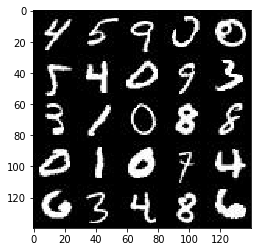

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

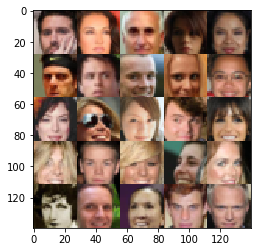

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/vladhc/.local/bin/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32,
                                shape=(None, image_height, image_width, image_channels),
                                name='real_images_input')
    z = tf.placeholder(tf.float32,
                       shape=(None, z_dim),
                       name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # batch x 28 x 28 x chan
        
        alpha = tf.constant(0.05, name='alpha')
        dropout_rate = 0.5
        
        x = tf.layers.conv2d(images,
                             64, 5,
                             strides=2,
                             padding='SAME',
                             use_bias=False,
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.nn.leaky_relu(x, alpha)
        if dropout_rate > 0:
            x = tf.layers.dropout(x, rate=dropout_rate, training=True)
        
        # batch x 14 x 14 x 64
        
        x = tf.layers.conv2d(x,
                             128, 5,
                             strides=2,
                             padding='SAME',
                             use_bias=False,
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.nn.leaky_relu(x, alpha)
        if dropout_rate > 0:
            x = tf.layers.dropout(x, rate=dropout_rate, training=True)
        
        # batch x 7 x 7 x 128
        
        x = tf.layers.conv2d(x,
                             256, 7,
                             strides=1,
                             padding='VALID',
                             use_bias=False,
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.nn.leaky_relu(x, alpha)
        if dropout_rate > 0:
            x = tf.layers.dropout(x, rate=dropout_rate, training=True)
        
        # batch x 1 x 1 x 256
        
        x = tf.reshape(x, [-1, 256])
        
        # batch x 256
        
        logits = tf.layers.dense(x, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        outputs = tf.nn.sigmoid(logits)

    return outputs, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Instructions for updating:
Use the retry module or similar alternatives.
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        
        alpha = tf.constant(0.1, name='alpha')
        
        x = tf.layers.dense(z, 512)
        x = tf.reshape(x, [-1, 1, 1, 512])
        
        # batch x 1 x 1 x 512
        
        x = tf.layers.conv2d_transpose(x,
                                       128, 7,
                                       strides=1,
                                       padding='VALID',
                                       use_bias=False,
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.nn.leaky_relu(x, alpha)
        
        # batch x 7 x 7 x 128
        
        x = tf.layers.conv2d_transpose(x,
                                       64, 5,
                                       strides=2,
                                       padding='SAME',
                                       use_bias=False,
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.nn.leaky_relu(x, alpha)
        
        # batch x 14 x 14 x 64
        
        x = tf.layers.conv2d_transpose(x,
                                       out_channel_dim, 5,
                                       strides=2,
                                       padding='SAME',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.tanh(x)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    input_fake = generator(input_z, out_channel_dim, is_train=True)
    
    d_real_out, d_real_logits = discriminator(input_real, reuse=False)
    d_fake_out, d_fake_logits = discriminator(input_fake, reuse=True)
    
    d_real_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.random_uniform(tf.shape(d_real_logits), minval=0.7, maxval=1.2),
            logits=d_real_logits))
    
    d_fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.random_uniform(tf.shape(d_fake_logits), minval=0, maxval=0.3),
            logits=d_fake_logits))
        
    d_loss = d_real_loss + d_fake_loss
    
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.ones_like(d_fake_logits),
            logits=d_fake_logits))
    
    return d_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    d_vars = tf.trainable_variables(scope='discriminator')
    g_vars = tf.trainable_variables(scope='generator')
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    print_every = 10
    show_every = 100
    show_images_count = 25
    
    _, width, height, channels = data_shape
    real_input, z, learning_rate_placeholder = model_inputs(width, height, channels, z_dim)
    d_loss_op, g_loss_op = model_loss(real_input, z, channels)
    d_train, g_train = model_opt(d_loss_op, g_loss_op, learning_rate_placeholder, beta1)
    
    d_stat_op = tf.summary.scalar('discriminator_loss', d_loss_op, family='losses')
    g_stat_op = tf.summary.scalar('generator_loss', g_loss_op, family='losses')
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                feed_dict = {
                    real_input: batch_images,
                    z: batch_z,
                    learning_rate_placeholder: learning_rate,
                }
                
                # Real images, which we are trying to fake, are in range [-0.5, 0.5]
                # But fake images are in the range (-1, 1).
                # So, we have to match them.
                batch_images = batch_images * 2
                
                _, d_stat, d_loss = sess.run([d_train, d_stat_op, d_loss_op], feed_dict=feed_dict)
                _, g_stat, g_loss = sess.run([g_train, g_stat_op, g_loss_op], feed_dict=feed_dict)
                
                if steps % print_every == 0:
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_loss),
                          "Generator Loss: {:.4f}".format(g_loss))

                if steps % show_every == 0:
                    show_generator_output(sess, show_images_count, z, channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.7668... Generator Loss: 0.7829
Epoch 1/2... Discriminator Loss: 1.5355... Generator Loss: 0.7231
Epoch 1/2... Discriminator Loss: 1.4458... Generator Loss: 0.6959
Epoch 1/2... Discriminator Loss: 1.4334... Generator Loss: 0.6128
Epoch 1/2... Discriminator Loss: 1.3576... Generator Loss: 0.6823
Epoch 1/2... Discriminator Loss: 1.3739... Generator Loss: 0.6357
Epoch 1/2... Discriminator Loss: 1.3563... Generator Loss: 0.6317
Epoch 1/2... Discriminator Loss: 1.3235... Generator Loss: 0.6643
Epoch 1/2... Discriminator Loss: 1.3538... Generator Loss: 0.6572
Epoch 1/2... Discriminator Loss: 1.3439... Generator Loss: 0.6350


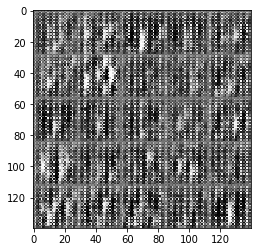

Epoch 1/2... Discriminator Loss: 1.3280... Generator Loss: 0.6477
Epoch 1/2... Discriminator Loss: 1.3845... Generator Loss: 0.5946
Epoch 1/2... Discriminator Loss: 1.3562... Generator Loss: 0.6533
Epoch 1/2... Discriminator Loss: 1.3815... Generator Loss: 0.6854
Epoch 1/2... Discriminator Loss: 1.3736... Generator Loss: 0.6180
Epoch 1/2... Discriminator Loss: 1.3858... Generator Loss: 0.6287
Epoch 1/2... Discriminator Loss: 1.3500... Generator Loss: 0.6556
Epoch 1/2... Discriminator Loss: 1.3734... Generator Loss: 0.6548
Epoch 1/2... Discriminator Loss: 1.3708... Generator Loss: 0.6247
Epoch 1/2... Discriminator Loss: 1.3736... Generator Loss: 0.6131


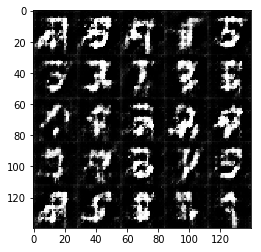

Epoch 1/2... Discriminator Loss: 1.3954... Generator Loss: 0.6273
Epoch 1/2... Discriminator Loss: 1.3568... Generator Loss: 0.6155
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.6041
Epoch 1/2... Discriminator Loss: 1.3753... Generator Loss: 0.6755
Epoch 1/2... Discriminator Loss: 1.3549... Generator Loss: 0.6540
Epoch 1/2... Discriminator Loss: 1.3705... Generator Loss: 0.6229
Epoch 1/2... Discriminator Loss: 1.3640... Generator Loss: 0.6257
Epoch 1/2... Discriminator Loss: 1.3716... Generator Loss: 0.6485
Epoch 1/2... Discriminator Loss: 1.3638... Generator Loss: 0.6080
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.6101


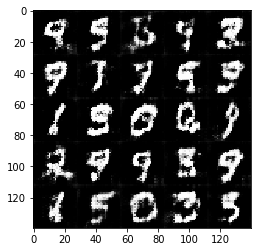

Epoch 1/2... Discriminator Loss: 1.3700... Generator Loss: 0.6288
Epoch 1/2... Discriminator Loss: 1.3810... Generator Loss: 0.6070
Epoch 1/2... Discriminator Loss: 1.3709... Generator Loss: 0.6280
Epoch 1/2... Discriminator Loss: 1.3577... Generator Loss: 0.6434
Epoch 1/2... Discriminator Loss: 1.3824... Generator Loss: 0.6396
Epoch 1/2... Discriminator Loss: 1.3671... Generator Loss: 0.5843
Epoch 1/2... Discriminator Loss: 1.3787... Generator Loss: 0.6235
Epoch 1/2... Discriminator Loss: 1.3847... Generator Loss: 0.6419
Epoch 1/2... Discriminator Loss: 1.3682... Generator Loss: 0.6540
Epoch 1/2... Discriminator Loss: 1.3499... Generator Loss: 0.6083


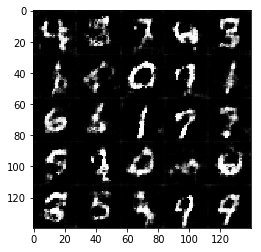

Epoch 1/2... Discriminator Loss: 1.3783... Generator Loss: 0.6256
Epoch 1/2... Discriminator Loss: 1.3541... Generator Loss: 0.6310
Epoch 1/2... Discriminator Loss: 1.3644... Generator Loss: 0.6436
Epoch 1/2... Discriminator Loss: 1.3697... Generator Loss: 0.6200
Epoch 1/2... Discriminator Loss: 1.3621... Generator Loss: 0.6299
Epoch 1/2... Discriminator Loss: 1.3720... Generator Loss: 0.6024
Epoch 2/2... Discriminator Loss: 1.3680... Generator Loss: 0.6453
Epoch 2/2... Discriminator Loss: 1.3570... Generator Loss: 0.6055
Epoch 2/2... Discriminator Loss: 1.3551... Generator Loss: 0.6297
Epoch 2/2... Discriminator Loss: 1.3589... Generator Loss: 0.6285


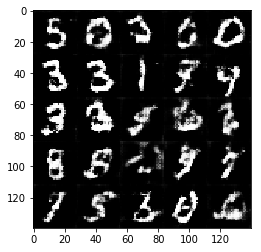

Epoch 2/2... Discriminator Loss: 1.3770... Generator Loss: 0.6134
Epoch 2/2... Discriminator Loss: 1.3772... Generator Loss: 0.6316
Epoch 2/2... Discriminator Loss: 1.3377... Generator Loss: 0.6300
Epoch 2/2... Discriminator Loss: 1.3575... Generator Loss: 0.6235
Epoch 2/2... Discriminator Loss: 1.3708... Generator Loss: 0.6355
Epoch 2/2... Discriminator Loss: 1.3425... Generator Loss: 0.6188
Epoch 2/2... Discriminator Loss: 1.3540... Generator Loss: 0.6366
Epoch 2/2... Discriminator Loss: 1.3841... Generator Loss: 0.6183
Epoch 2/2... Discriminator Loss: 1.3568... Generator Loss: 0.6430
Epoch 2/2... Discriminator Loss: 1.3537... Generator Loss: 0.6328


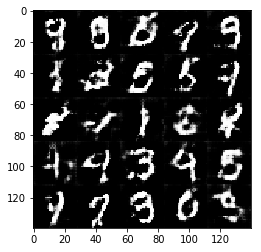

Epoch 2/2... Discriminator Loss: 1.3461... Generator Loss: 0.6295
Epoch 2/2... Discriminator Loss: 1.3454... Generator Loss: 0.6522
Epoch 2/2... Discriminator Loss: 1.3584... Generator Loss: 0.6329
Epoch 2/2... Discriminator Loss: 1.3589... Generator Loss: 0.6367
Epoch 2/2... Discriminator Loss: 1.3333... Generator Loss: 0.6232
Epoch 2/2... Discriminator Loss: 1.3864... Generator Loss: 0.6377
Epoch 2/2... Discriminator Loss: 1.3784... Generator Loss: 0.6256
Epoch 2/2... Discriminator Loss: 1.3688... Generator Loss: 0.6574
Epoch 2/2... Discriminator Loss: 1.3414... Generator Loss: 0.6319
Epoch 2/2... Discriminator Loss: 1.3571... Generator Loss: 0.6566


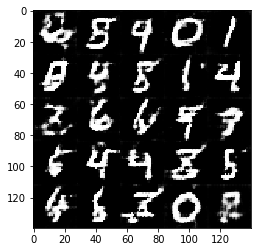

Epoch 2/2... Discriminator Loss: 1.3775... Generator Loss: 0.6455
Epoch 2/2... Discriminator Loss: 1.3570... Generator Loss: 0.6149
Epoch 2/2... Discriminator Loss: 1.3732... Generator Loss: 0.6324
Epoch 2/2... Discriminator Loss: 1.3517... Generator Loss: 0.6474
Epoch 2/2... Discriminator Loss: 1.3716... Generator Loss: 0.6439
Epoch 2/2... Discriminator Loss: 1.3553... Generator Loss: 0.6533
Epoch 2/2... Discriminator Loss: 1.3568... Generator Loss: 0.6436
Epoch 2/2... Discriminator Loss: 1.3868... Generator Loss: 0.6653
Epoch 2/2... Discriminator Loss: 1.3382... Generator Loss: 0.6405
Epoch 2/2... Discriminator Loss: 1.3747... Generator Loss: 0.6702


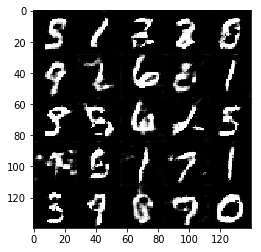

Epoch 2/2... Discriminator Loss: 1.3671... Generator Loss: 0.6388
Epoch 2/2... Discriminator Loss: 1.3493... Generator Loss: 0.6483
Epoch 2/2... Discriminator Loss: 1.3565... Generator Loss: 0.6805
Epoch 2/2... Discriminator Loss: 1.3661... Generator Loss: 0.6254
Epoch 2/2... Discriminator Loss: 1.3429... Generator Loss: 0.6471
Epoch 2/2... Discriminator Loss: 1.3354... Generator Loss: 0.6428
Epoch 2/2... Discriminator Loss: 1.3511... Generator Loss: 0.6367
Epoch 2/2... Discriminator Loss: 1.3385... Generator Loss: 0.6934
Epoch 2/2... Discriminator Loss: 1.3083... Generator Loss: 0.6872
Epoch 2/2... Discriminator Loss: 1.3399... Generator Loss: 0.6769


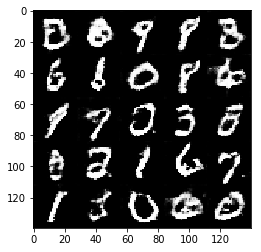

Epoch 2/2... Discriminator Loss: 1.3517... Generator Loss: 0.6757
Epoch 2/2... Discriminator Loss: 1.3291... Generator Loss: 0.6730
Epoch 2/2... Discriminator Loss: 1.3189... Generator Loss: 0.6572


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.004
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/5... Discriminator Loss: 1.6655... Generator Loss: 0.8696
Epoch 1/5... Discriminator Loss: 1.3926... Generator Loss: 0.6943
Epoch 1/5... Discriminator Loss: 1.4448... Generator Loss: 0.7107
Epoch 1/5... Discriminator Loss: 1.5611... Generator Loss: 0.7272
Epoch 1/5... Discriminator Loss: 1.4913... Generator Loss: 0.7980
Epoch 1/5... Discriminator Loss: 1.4550... Generator Loss: 0.6915
Epoch 1/5... Discriminator Loss: 1.3552... Generator Loss: 0.6945
Epoch 1/5... Discriminator Loss: 1.4496... Generator Loss: 0.6280
Epoch 1/5... Discriminator Loss: 1.4212... Generator Loss: 0.6759
Epoch 1/5... Discriminator Loss: 1.4127... Generator Loss: 0.6752


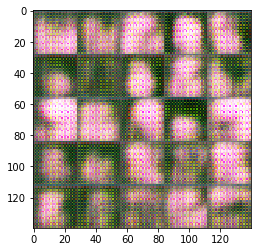

Epoch 1/5... Discriminator Loss: 1.4263... Generator Loss: 0.6811
Epoch 1/5... Discriminator Loss: 1.3888... Generator Loss: 0.6459
Epoch 1/5... Discriminator Loss: 1.3634... Generator Loss: 0.6702
Epoch 1/5... Discriminator Loss: 1.4022... Generator Loss: 0.5851
Epoch 1/5... Discriminator Loss: 1.3832... Generator Loss: 0.6112
Epoch 1/5... Discriminator Loss: 1.3971... Generator Loss: 0.6720
Epoch 1/5... Discriminator Loss: 1.3791... Generator Loss: 0.6337
Epoch 1/5... Discriminator Loss: 1.3750... Generator Loss: 0.6504
Epoch 1/5... Discriminator Loss: 1.3892... Generator Loss: 0.6688
Epoch 1/5... Discriminator Loss: 1.3634... Generator Loss: 0.6278


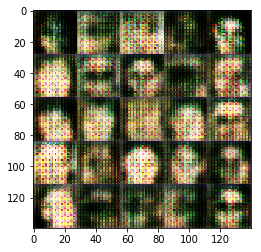

Epoch 1/5... Discriminator Loss: 1.3860... Generator Loss: 0.5883
Epoch 1/5... Discriminator Loss: 1.3795... Generator Loss: 0.5694
Epoch 1/5... Discriminator Loss: 1.4013... Generator Loss: 0.6126
Epoch 1/5... Discriminator Loss: 1.3734... Generator Loss: 0.6039
Epoch 1/5... Discriminator Loss: 1.3877... Generator Loss: 0.6301
Epoch 1/5... Discriminator Loss: 1.3840... Generator Loss: 0.5965
Epoch 1/5... Discriminator Loss: 1.3833... Generator Loss: 0.6195
Epoch 1/5... Discriminator Loss: 1.3655... Generator Loss: 0.5857
Epoch 1/5... Discriminator Loss: 1.3764... Generator Loss: 0.6386
Epoch 1/5... Discriminator Loss: 1.3845... Generator Loss: 0.6202


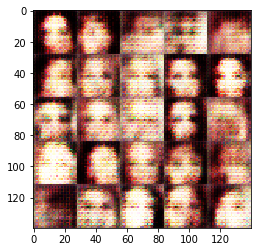

Epoch 1/5... Discriminator Loss: 1.3767... Generator Loss: 0.6184
Epoch 1/5... Discriminator Loss: 1.3732... Generator Loss: 0.6064
Epoch 1/5... Discriminator Loss: 1.3739... Generator Loss: 0.6310
Epoch 1/5... Discriminator Loss: 1.3876... Generator Loss: 0.5766
Epoch 1/5... Discriminator Loss: 1.3781... Generator Loss: 0.6564
Epoch 1/5... Discriminator Loss: 1.3741... Generator Loss: 0.6536
Epoch 1/5... Discriminator Loss: 1.3793... Generator Loss: 0.6497
Epoch 1/5... Discriminator Loss: 1.3901... Generator Loss: 0.5754
Epoch 1/5... Discriminator Loss: 1.3818... Generator Loss: 0.6545
Epoch 1/5... Discriminator Loss: 1.3665... Generator Loss: 0.5960


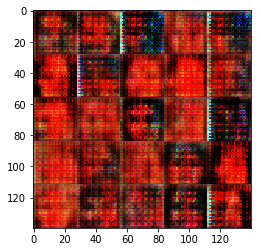

Epoch 1/5... Discriminator Loss: 1.4047... Generator Loss: 0.6068
Epoch 1/5... Discriminator Loss: 1.4110... Generator Loss: 0.6339
Epoch 1/5... Discriminator Loss: 1.4028... Generator Loss: 0.6167
Epoch 1/5... Discriminator Loss: 1.3876... Generator Loss: 0.5998
Epoch 1/5... Discriminator Loss: 1.3765... Generator Loss: 0.6243
Epoch 1/5... Discriminator Loss: 1.3870... Generator Loss: 0.6500
Epoch 1/5... Discriminator Loss: 1.3809... Generator Loss: 0.5881
Epoch 1/5... Discriminator Loss: 1.3650... Generator Loss: 0.6158
Epoch 1/5... Discriminator Loss: 1.3858... Generator Loss: 0.5821
Epoch 1/5... Discriminator Loss: 1.3638... Generator Loss: 0.6147


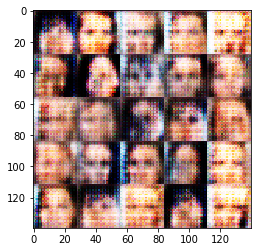

Epoch 1/5... Discriminator Loss: 1.3784... Generator Loss: 0.6191
Epoch 1/5... Discriminator Loss: 1.3912... Generator Loss: 0.6034
Epoch 1/5... Discriminator Loss: 1.3817... Generator Loss: 0.6062
Epoch 1/5... Discriminator Loss: 1.3903... Generator Loss: 0.6143
Epoch 1/5... Discriminator Loss: 1.3923... Generator Loss: 0.6200
Epoch 1/5... Discriminator Loss: 1.3729... Generator Loss: 0.6190
Epoch 1/5... Discriminator Loss: 1.3720... Generator Loss: 0.6098
Epoch 1/5... Discriminator Loss: 1.3786... Generator Loss: 0.5949
Epoch 1/5... Discriminator Loss: 1.3863... Generator Loss: 0.6507
Epoch 1/5... Discriminator Loss: 1.3717... Generator Loss: 0.6206


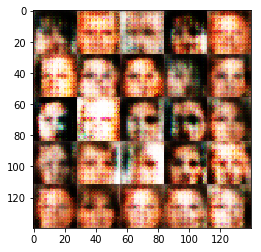

Epoch 1/5... Discriminator Loss: 1.3659... Generator Loss: 0.6129
Epoch 1/5... Discriminator Loss: 1.3697... Generator Loss: 0.6261
Epoch 1/5... Discriminator Loss: 1.3817... Generator Loss: 0.5926
Epoch 1/5... Discriminator Loss: 1.3832... Generator Loss: 0.6352
Epoch 1/5... Discriminator Loss: 1.3739... Generator Loss: 0.6319
Epoch 1/5... Discriminator Loss: 1.3775... Generator Loss: 0.6208
Epoch 1/5... Discriminator Loss: 1.3907... Generator Loss: 0.6322
Epoch 1/5... Discriminator Loss: 1.3676... Generator Loss: 0.5981
Epoch 1/5... Discriminator Loss: 1.3660... Generator Loss: 0.6608
Epoch 1/5... Discriminator Loss: 1.3859... Generator Loss: 0.6459


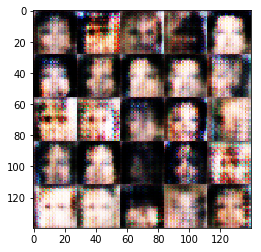

Epoch 1/5... Discriminator Loss: 1.3766... Generator Loss: 0.6161
Epoch 1/5... Discriminator Loss: 1.3911... Generator Loss: 0.5874
Epoch 1/5... Discriminator Loss: 1.3672... Generator Loss: 0.6072
Epoch 1/5... Discriminator Loss: 1.3947... Generator Loss: 0.6550
Epoch 1/5... Discriminator Loss: 1.3816... Generator Loss: 0.6498
Epoch 1/5... Discriminator Loss: 1.3864... Generator Loss: 0.6280
Epoch 1/5... Discriminator Loss: 1.3904... Generator Loss: 0.6047
Epoch 1/5... Discriminator Loss: 1.3750... Generator Loss: 0.6061
Epoch 1/5... Discriminator Loss: 1.3854... Generator Loss: 0.6114
Epoch 1/5... Discriminator Loss: 1.3939... Generator Loss: 0.6162


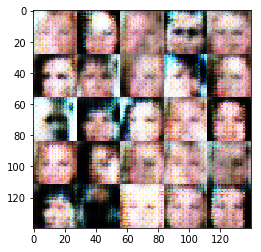

Epoch 1/5... Discriminator Loss: 1.3636... Generator Loss: 0.6131
Epoch 1/5... Discriminator Loss: 1.3903... Generator Loss: 0.6151
Epoch 1/5... Discriminator Loss: 1.3770... Generator Loss: 0.5924
Epoch 1/5... Discriminator Loss: 1.3610... Generator Loss: 0.6414
Epoch 1/5... Discriminator Loss: 1.3841... Generator Loss: 0.6018
Epoch 1/5... Discriminator Loss: 1.3931... Generator Loss: 0.6270
Epoch 1/5... Discriminator Loss: 1.3728... Generator Loss: 0.6351
Epoch 1/5... Discriminator Loss: 1.3742... Generator Loss: 0.6365
Epoch 1/5... Discriminator Loss: 1.3714... Generator Loss: 0.6031
Epoch 1/5... Discriminator Loss: 1.3745... Generator Loss: 0.6067


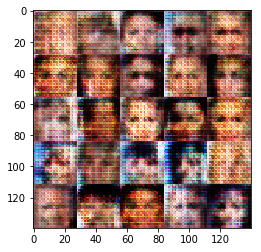

Epoch 1/5... Discriminator Loss: 1.3798... Generator Loss: 0.6093
Epoch 1/5... Discriminator Loss: 1.3988... Generator Loss: 0.6436
Epoch 1/5... Discriminator Loss: 1.3580... Generator Loss: 0.6389
Epoch 1/5... Discriminator Loss: 1.3678... Generator Loss: 0.6051
Epoch 1/5... Discriminator Loss: 1.3743... Generator Loss: 0.6220
Epoch 1/5... Discriminator Loss: 1.3789... Generator Loss: 0.6324
Epoch 1/5... Discriminator Loss: 1.3958... Generator Loss: 0.6103
Epoch 1/5... Discriminator Loss: 1.3766... Generator Loss: 0.5892
Epoch 1/5... Discriminator Loss: 1.3797... Generator Loss: 0.6219
Epoch 1/5... Discriminator Loss: 1.3751... Generator Loss: 0.5853


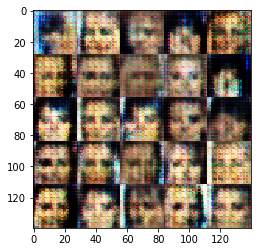

Epoch 1/5... Discriminator Loss: 1.3768... Generator Loss: 0.6167
Epoch 1/5... Discriminator Loss: 1.3802... Generator Loss: 0.5723
Epoch 1/5... Discriminator Loss: 1.3803... Generator Loss: 0.6339
Epoch 1/5... Discriminator Loss: 1.3862... Generator Loss: 0.6176
Epoch 1/5... Discriminator Loss: 1.3687... Generator Loss: 0.6307
Epoch 1/5... Discriminator Loss: 1.3567... Generator Loss: 0.5968
Epoch 1/5... Discriminator Loss: 1.3727... Generator Loss: 0.6213
Epoch 1/5... Discriminator Loss: 1.3687... Generator Loss: 0.5833
Epoch 1/5... Discriminator Loss: 1.3769... Generator Loss: 0.6315
Epoch 1/5... Discriminator Loss: 1.3572... Generator Loss: 0.6045


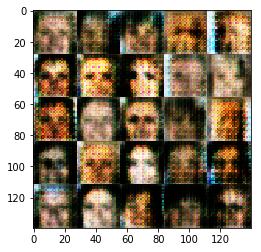

Epoch 1/5... Discriminator Loss: 1.3793... Generator Loss: 0.6221
Epoch 1/5... Discriminator Loss: 1.3919... Generator Loss: 0.6072
Epoch 1/5... Discriminator Loss: 1.3606... Generator Loss: 0.5919
Epoch 1/5... Discriminator Loss: 1.3717... Generator Loss: 0.6338
Epoch 1/5... Discriminator Loss: 1.3953... Generator Loss: 0.6021
Epoch 1/5... Discriminator Loss: 1.3631... Generator Loss: 0.6515
Epoch 1/5... Discriminator Loss: 1.3747... Generator Loss: 0.6245
Epoch 1/5... Discriminator Loss: 1.3777... Generator Loss: 0.5869
Epoch 1/5... Discriminator Loss: 1.3682... Generator Loss: 0.6027
Epoch 1/5... Discriminator Loss: 1.3674... Generator Loss: 0.5966


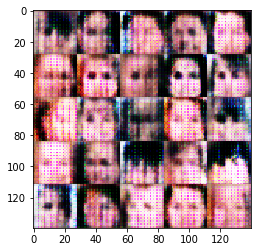

Epoch 1/5... Discriminator Loss: 1.3830... Generator Loss: 0.6604
Epoch 1/5... Discriminator Loss: 1.3749... Generator Loss: 0.6667
Epoch 1/5... Discriminator Loss: 1.3781... Generator Loss: 0.6073
Epoch 1/5... Discriminator Loss: 1.3621... Generator Loss: 0.6295
Epoch 1/5... Discriminator Loss: 1.3899... Generator Loss: 0.6271
Epoch 1/5... Discriminator Loss: 1.3769... Generator Loss: 0.6026
Epoch 1/5... Discriminator Loss: 1.3568... Generator Loss: 0.6031
Epoch 1/5... Discriminator Loss: 1.3810... Generator Loss: 0.6052
Epoch 1/5... Discriminator Loss: 1.3647... Generator Loss: 0.6265
Epoch 1/5... Discriminator Loss: 1.3555... Generator Loss: 0.6097


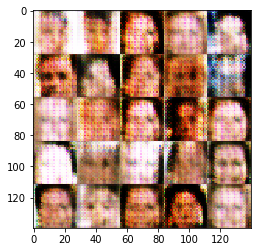

Epoch 1/5... Discriminator Loss: 1.3692... Generator Loss: 0.6139
Epoch 1/5... Discriminator Loss: 1.3797... Generator Loss: 0.5997
Epoch 1/5... Discriminator Loss: 1.3607... Generator Loss: 0.6158
Epoch 1/5... Discriminator Loss: 1.3470... Generator Loss: 0.6042
Epoch 1/5... Discriminator Loss: 1.3657... Generator Loss: 0.6084
Epoch 1/5... Discriminator Loss: 1.3621... Generator Loss: 0.6284
Epoch 1/5... Discriminator Loss: 1.3964... Generator Loss: 0.6305
Epoch 1/5... Discriminator Loss: 1.3834... Generator Loss: 0.6367
Epoch 1/5... Discriminator Loss: 1.3633... Generator Loss: 0.6337
Epoch 1/5... Discriminator Loss: 1.3692... Generator Loss: 0.6473


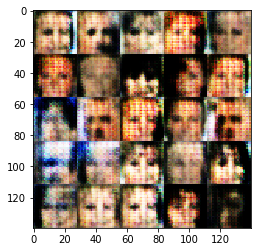

Epoch 1/5... Discriminator Loss: 1.4020... Generator Loss: 0.5884
Epoch 1/5... Discriminator Loss: 1.3595... Generator Loss: 0.6439
Epoch 1/5... Discriminator Loss: 1.3582... Generator Loss: 0.5867
Epoch 1/5... Discriminator Loss: 1.3579... Generator Loss: 0.6299
Epoch 1/5... Discriminator Loss: 1.3590... Generator Loss: 0.6235
Epoch 1/5... Discriminator Loss: 1.3626... Generator Loss: 0.6466
Epoch 1/5... Discriminator Loss: 1.3605... Generator Loss: 0.6386
Epoch 1/5... Discriminator Loss: 1.3691... Generator Loss: 0.6134
Epoch 1/5... Discriminator Loss: 1.3883... Generator Loss: 0.6554
Epoch 1/5... Discriminator Loss: 1.3866... Generator Loss: 0.6343


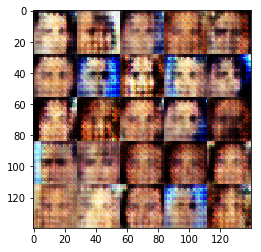

Epoch 1/5... Discriminator Loss: 1.3961... Generator Loss: 0.6185
Epoch 1/5... Discriminator Loss: 1.3544... Generator Loss: 0.6907
Epoch 1/5... Discriminator Loss: 1.3819... Generator Loss: 0.6004
Epoch 1/5... Discriminator Loss: 1.3574... Generator Loss: 0.6050
Epoch 1/5... Discriminator Loss: 1.3509... Generator Loss: 0.6452
Epoch 1/5... Discriminator Loss: 1.3647... Generator Loss: 0.6530
Epoch 1/5... Discriminator Loss: 1.3492... Generator Loss: 0.6463
Epoch 1/5... Discriminator Loss: 1.3512... Generator Loss: 0.6096
Epoch 2/5... Discriminator Loss: 1.3733... Generator Loss: 0.6249
Epoch 2/5... Discriminator Loss: 1.4074... Generator Loss: 0.6145


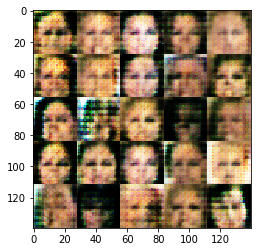

Epoch 2/5... Discriminator Loss: 1.3988... Generator Loss: 0.6142
Epoch 2/5... Discriminator Loss: 1.3725... Generator Loss: 0.6551
Epoch 2/5... Discriminator Loss: 1.3744... Generator Loss: 0.6430
Epoch 2/5... Discriminator Loss: 1.3836... Generator Loss: 0.6259
Epoch 2/5... Discriminator Loss: 1.3806... Generator Loss: 0.6116
Epoch 2/5... Discriminator Loss: 1.3667... Generator Loss: 0.5926
Epoch 2/5... Discriminator Loss: 1.3694... Generator Loss: 0.6763
Epoch 2/5... Discriminator Loss: 1.3643... Generator Loss: 0.6238
Epoch 2/5... Discriminator Loss: 1.3689... Generator Loss: 0.6282
Epoch 2/5... Discriminator Loss: 1.3605... Generator Loss: 0.5969


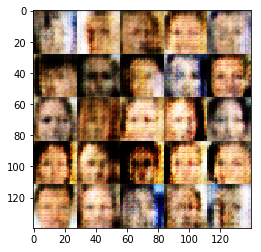

Epoch 2/5... Discriminator Loss: 1.3854... Generator Loss: 0.6025
Epoch 2/5... Discriminator Loss: 1.3854... Generator Loss: 0.6019
Epoch 2/5... Discriminator Loss: 1.3839... Generator Loss: 0.6439
Epoch 2/5... Discriminator Loss: 1.3770... Generator Loss: 0.6316
Epoch 2/5... Discriminator Loss: 1.3628... Generator Loss: 0.5716
Epoch 2/5... Discriminator Loss: 1.3413... Generator Loss: 0.6158
Epoch 2/5... Discriminator Loss: 1.3727... Generator Loss: 0.6265
Epoch 2/5... Discriminator Loss: 1.3678... Generator Loss: 0.6382
Epoch 2/5... Discriminator Loss: 1.3897... Generator Loss: 0.6481
Epoch 2/5... Discriminator Loss: 1.3698... Generator Loss: 0.6718


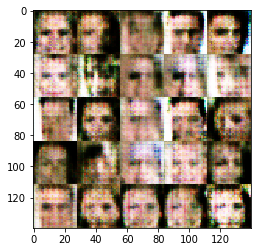

Epoch 2/5... Discriminator Loss: 1.3577... Generator Loss: 0.6691
Epoch 2/5... Discriminator Loss: 1.3685... Generator Loss: 0.6960
Epoch 2/5... Discriminator Loss: 1.3819... Generator Loss: 0.6377
Epoch 2/5... Discriminator Loss: 1.3355... Generator Loss: 0.6380
Epoch 2/5... Discriminator Loss: 1.3516... Generator Loss: 0.6466
Epoch 2/5... Discriminator Loss: 1.3916... Generator Loss: 0.6399
Epoch 2/5... Discriminator Loss: 1.3833... Generator Loss: 0.6325
Epoch 2/5... Discriminator Loss: 1.3635... Generator Loss: 0.6127
Epoch 2/5... Discriminator Loss: 1.3651... Generator Loss: 0.6116
Epoch 2/5... Discriminator Loss: 1.3866... Generator Loss: 0.6270


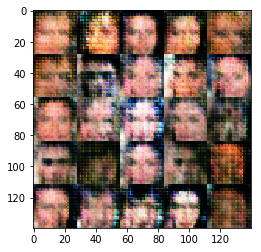

Epoch 2/5... Discriminator Loss: 1.3731... Generator Loss: 0.6285
Epoch 2/5... Discriminator Loss: 1.3545... Generator Loss: 0.6423
Epoch 2/5... Discriminator Loss: 1.3413... Generator Loss: 0.7062
Epoch 2/5... Discriminator Loss: 1.3684... Generator Loss: 0.6290
Epoch 2/5... Discriminator Loss: 1.3352... Generator Loss: 0.6820
Epoch 2/5... Discriminator Loss: 1.3844... Generator Loss: 0.6434
Epoch 2/5... Discriminator Loss: 1.3687... Generator Loss: 0.6082
Epoch 2/5... Discriminator Loss: 1.3730... Generator Loss: 0.6116
Epoch 2/5... Discriminator Loss: 1.3698... Generator Loss: 0.6584
Epoch 2/5... Discriminator Loss: 1.3305... Generator Loss: 0.6029


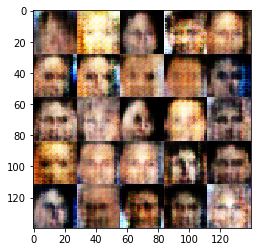

Epoch 2/5... Discriminator Loss: 1.3876... Generator Loss: 0.6459
Epoch 2/5... Discriminator Loss: 1.3673... Generator Loss: 0.6339
Epoch 2/5... Discriminator Loss: 1.3769... Generator Loss: 0.6345
Epoch 2/5... Discriminator Loss: 1.3885... Generator Loss: 0.6280
Epoch 2/5... Discriminator Loss: 1.4060... Generator Loss: 0.6914
Epoch 2/5... Discriminator Loss: 1.3534... Generator Loss: 0.6221
Epoch 2/5... Discriminator Loss: 1.3696... Generator Loss: 0.6243
Epoch 2/5... Discriminator Loss: 1.3999... Generator Loss: 0.6545
Epoch 2/5... Discriminator Loss: 1.3747... Generator Loss: 0.6714
Epoch 2/5... Discriminator Loss: 1.3684... Generator Loss: 0.6458


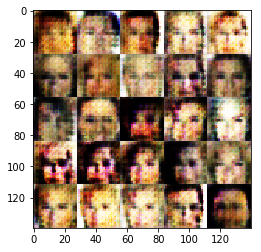

Epoch 2/5... Discriminator Loss: 1.3852... Generator Loss: 0.6042
Epoch 2/5... Discriminator Loss: 1.3513... Generator Loss: 0.6128
Epoch 2/5... Discriminator Loss: 1.4022... Generator Loss: 0.6330
Epoch 2/5... Discriminator Loss: 1.3827... Generator Loss: 0.6381
Epoch 2/5... Discriminator Loss: 1.3744... Generator Loss: 0.6331
Epoch 2/5... Discriminator Loss: 1.3896... Generator Loss: 0.6156
Epoch 2/5... Discriminator Loss: 1.3433... Generator Loss: 0.6855
Epoch 2/5... Discriminator Loss: 1.3151... Generator Loss: 0.6400
Epoch 2/5... Discriminator Loss: 1.2773... Generator Loss: 0.7036
Epoch 2/5... Discriminator Loss: 1.3532... Generator Loss: 0.6486


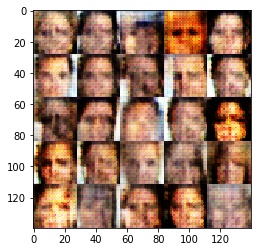

Epoch 2/5... Discriminator Loss: 1.3724... Generator Loss: 0.6939
Epoch 2/5... Discriminator Loss: 1.3420... Generator Loss: 0.6947
Epoch 2/5... Discriminator Loss: 1.3257... Generator Loss: 0.6277
Epoch 2/5... Discriminator Loss: 1.3384... Generator Loss: 0.6879
Epoch 2/5... Discriminator Loss: 1.3517... Generator Loss: 0.6525
Epoch 2/5... Discriminator Loss: 1.3624... Generator Loss: 0.6500
Epoch 2/5... Discriminator Loss: 1.4148... Generator Loss: 0.6432
Epoch 2/5... Discriminator Loss: 1.3396... Generator Loss: 0.6736
Epoch 2/5... Discriminator Loss: 1.3600... Generator Loss: 0.6719
Epoch 2/5... Discriminator Loss: 1.3778... Generator Loss: 0.6984


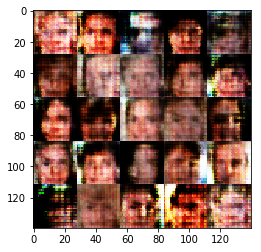

Epoch 2/5... Discriminator Loss: 1.3786... Generator Loss: 0.5963
Epoch 2/5... Discriminator Loss: 1.3636... Generator Loss: 0.6673
Epoch 2/5... Discriminator Loss: 1.3606... Generator Loss: 0.6621
Epoch 2/5... Discriminator Loss: 1.3196... Generator Loss: 0.6853
Epoch 2/5... Discriminator Loss: 1.3171... Generator Loss: 0.7485
Epoch 2/5... Discriminator Loss: 1.3798... Generator Loss: 0.6740
Epoch 2/5... Discriminator Loss: 1.3749... Generator Loss: 0.6917
Epoch 2/5... Discriminator Loss: 1.3740... Generator Loss: 0.7305
Epoch 2/5... Discriminator Loss: 1.3750... Generator Loss: 0.6736
Epoch 2/5... Discriminator Loss: 1.3183... Generator Loss: 0.6903


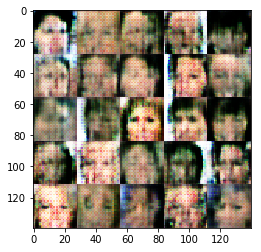

Epoch 2/5... Discriminator Loss: 1.3618... Generator Loss: 0.6890
Epoch 2/5... Discriminator Loss: 1.3889... Generator Loss: 0.6566
Epoch 2/5... Discriminator Loss: 1.3660... Generator Loss: 0.6421
Epoch 2/5... Discriminator Loss: 1.3623... Generator Loss: 0.6792
Epoch 2/5... Discriminator Loss: 1.3792... Generator Loss: 0.7122
Epoch 2/5... Discriminator Loss: 1.3727... Generator Loss: 0.6941
Epoch 2/5... Discriminator Loss: 1.3902... Generator Loss: 0.6461
Epoch 2/5... Discriminator Loss: 1.3592... Generator Loss: 0.6181
Epoch 2/5... Discriminator Loss: 1.3701... Generator Loss: 0.6485
Epoch 2/5... Discriminator Loss: 1.3544... Generator Loss: 0.6309


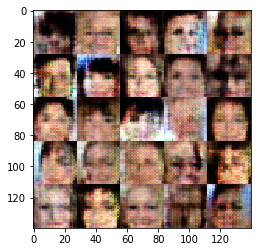

Epoch 2/5... Discriminator Loss: 1.3862... Generator Loss: 0.6307
Epoch 2/5... Discriminator Loss: 1.3671... Generator Loss: 0.6251
Epoch 2/5... Discriminator Loss: 1.3568... Generator Loss: 0.6523
Epoch 2/5... Discriminator Loss: 1.3944... Generator Loss: 0.7131
Epoch 2/5... Discriminator Loss: 1.3463... Generator Loss: 0.6982
Epoch 2/5... Discriminator Loss: 1.3236... Generator Loss: 0.6655
Epoch 2/5... Discriminator Loss: 1.3282... Generator Loss: 0.6636
Epoch 2/5... Discriminator Loss: 1.3690... Generator Loss: 0.6031
Epoch 2/5... Discriminator Loss: 1.3639... Generator Loss: 0.6645
Epoch 2/5... Discriminator Loss: 1.3606... Generator Loss: 0.6339


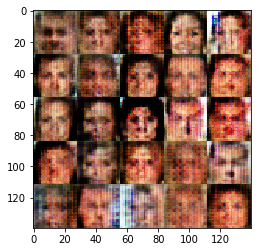

Epoch 2/5... Discriminator Loss: 1.3624... Generator Loss: 0.5958
Epoch 2/5... Discriminator Loss: 1.3764... Generator Loss: 0.6885
Epoch 2/5... Discriminator Loss: 1.3251... Generator Loss: 0.7301
Epoch 2/5... Discriminator Loss: 1.3673... Generator Loss: 0.6552
Epoch 2/5... Discriminator Loss: 1.3366... Generator Loss: 0.6518
Epoch 2/5... Discriminator Loss: 1.3412... Generator Loss: 0.6577
Epoch 2/5... Discriminator Loss: 1.3355... Generator Loss: 0.7000
Epoch 2/5... Discriminator Loss: 1.3313... Generator Loss: 0.6659
Epoch 2/5... Discriminator Loss: 1.3471... Generator Loss: 0.7115
Epoch 2/5... Discriminator Loss: 1.3658... Generator Loss: 0.6240


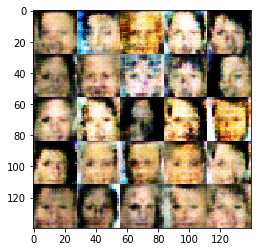

Epoch 2/5... Discriminator Loss: 1.3674... Generator Loss: 0.7058
Epoch 2/5... Discriminator Loss: 1.3022... Generator Loss: 0.6433
Epoch 2/5... Discriminator Loss: 1.3965... Generator Loss: 0.7427
Epoch 2/5... Discriminator Loss: 1.3897... Generator Loss: 0.6928
Epoch 2/5... Discriminator Loss: 1.3388... Generator Loss: 0.6958
Epoch 2/5... Discriminator Loss: 1.3107... Generator Loss: 0.6339
Epoch 2/5... Discriminator Loss: 1.3607... Generator Loss: 0.6761
Epoch 2/5... Discriminator Loss: 1.3640... Generator Loss: 0.6630
Epoch 2/5... Discriminator Loss: 1.3368... Generator Loss: 0.6337
Epoch 2/5... Discriminator Loss: 1.2999... Generator Loss: 0.6340


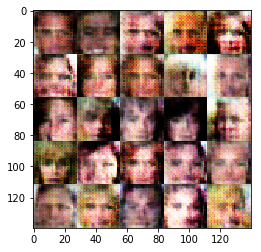

Epoch 2/5... Discriminator Loss: 1.3676... Generator Loss: 0.6485
Epoch 2/5... Discriminator Loss: 1.4226... Generator Loss: 0.6096
Epoch 2/5... Discriminator Loss: 1.2867... Generator Loss: 0.6645
Epoch 2/5... Discriminator Loss: 1.3437... Generator Loss: 0.6805
Epoch 2/5... Discriminator Loss: 1.3416... Generator Loss: 0.7219
Epoch 2/5... Discriminator Loss: 1.3607... Generator Loss: 0.6244
Epoch 2/5... Discriminator Loss: 1.3542... Generator Loss: 0.6313
Epoch 2/5... Discriminator Loss: 1.3708... Generator Loss: 0.6128
Epoch 2/5... Discriminator Loss: 1.3785... Generator Loss: 0.6816
Epoch 2/5... Discriminator Loss: 1.3076... Generator Loss: 0.6622


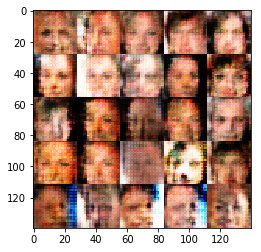

Epoch 2/5... Discriminator Loss: 1.3764... Generator Loss: 0.6348
Epoch 2/5... Discriminator Loss: 1.3574... Generator Loss: 0.6632
Epoch 2/5... Discriminator Loss: 1.3844... Generator Loss: 0.6799
Epoch 2/5... Discriminator Loss: 1.3744... Generator Loss: 0.6376
Epoch 2/5... Discriminator Loss: 1.3752... Generator Loss: 0.6616
Epoch 2/5... Discriminator Loss: 1.3830... Generator Loss: 0.6955
Epoch 2/5... Discriminator Loss: 1.3519... Generator Loss: 0.6627
Epoch 2/5... Discriminator Loss: 1.3339... Generator Loss: 0.7429
Epoch 2/5... Discriminator Loss: 1.3331... Generator Loss: 0.6417
Epoch 2/5... Discriminator Loss: 1.3706... Generator Loss: 0.6942


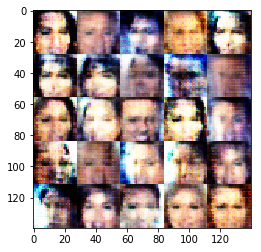

Epoch 2/5... Discriminator Loss: 1.3753... Generator Loss: 0.6669
Epoch 2/5... Discriminator Loss: 1.3542... Generator Loss: 0.6515
Epoch 2/5... Discriminator Loss: 1.3297... Generator Loss: 0.6332
Epoch 2/5... Discriminator Loss: 1.3364... Generator Loss: 0.5990
Epoch 2/5... Discriminator Loss: 1.3572... Generator Loss: 0.7636
Epoch 2/5... Discriminator Loss: 1.3875... Generator Loss: 0.6817
Epoch 2/5... Discriminator Loss: 1.3695... Generator Loss: 0.7077
Epoch 2/5... Discriminator Loss: 1.3833... Generator Loss: 0.6841
Epoch 2/5... Discriminator Loss: 1.3596... Generator Loss: 0.6673
Epoch 2/5... Discriminator Loss: 1.3575... Generator Loss: 0.6407


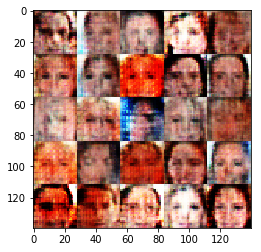

Epoch 2/5... Discriminator Loss: 1.3445... Generator Loss: 0.6600
Epoch 2/5... Discriminator Loss: 1.3441... Generator Loss: 0.6681
Epoch 2/5... Discriminator Loss: 1.3445... Generator Loss: 0.7021
Epoch 2/5... Discriminator Loss: 1.3624... Generator Loss: 0.6890
Epoch 2/5... Discriminator Loss: 1.3443... Generator Loss: 0.6401
Epoch 2/5... Discriminator Loss: 1.3415... Generator Loss: 0.6324
Epoch 3/5... Discriminator Loss: 1.3572... Generator Loss: 0.6828
Epoch 3/5... Discriminator Loss: 1.3023... Generator Loss: 0.6224
Epoch 3/5... Discriminator Loss: 1.3604... Generator Loss: 0.6670
Epoch 3/5... Discriminator Loss: 1.3264... Generator Loss: 0.7256


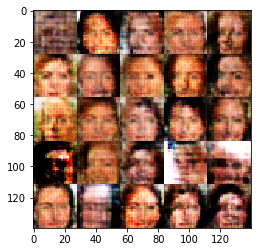

Epoch 3/5... Discriminator Loss: 1.3731... Generator Loss: 0.6358
Epoch 3/5... Discriminator Loss: 1.3972... Generator Loss: 0.6597
Epoch 3/5... Discriminator Loss: 1.3847... Generator Loss: 0.6649
Epoch 3/5... Discriminator Loss: 1.3541... Generator Loss: 0.6576
Epoch 3/5... Discriminator Loss: 1.3321... Generator Loss: 0.6048
Epoch 3/5... Discriminator Loss: 1.3703... Generator Loss: 0.6178
Epoch 3/5... Discriminator Loss: 1.3696... Generator Loss: 0.6606
Epoch 3/5... Discriminator Loss: 1.3883... Generator Loss: 0.6280
Epoch 3/5... Discriminator Loss: 1.3721... Generator Loss: 0.6790
Epoch 3/5... Discriminator Loss: 1.3911... Generator Loss: 0.6751


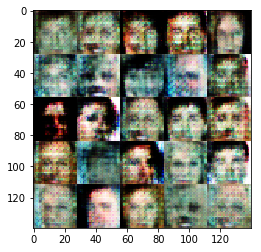

Epoch 3/5... Discriminator Loss: 1.4353... Generator Loss: 0.6936
Epoch 3/5... Discriminator Loss: 1.4335... Generator Loss: 0.6206
Epoch 3/5... Discriminator Loss: 1.3883... Generator Loss: 0.6754
Epoch 3/5... Discriminator Loss: 1.3348... Generator Loss: 0.6353
Epoch 3/5... Discriminator Loss: 1.3426... Generator Loss: 0.6171
Epoch 3/5... Discriminator Loss: 1.3479... Generator Loss: 0.6927
Epoch 3/5... Discriminator Loss: 1.3738... Generator Loss: 0.6591
Epoch 3/5... Discriminator Loss: 1.3334... Generator Loss: 0.6983
Epoch 3/5... Discriminator Loss: 1.3623... Generator Loss: 0.6396
Epoch 3/5... Discriminator Loss: 1.3767... Generator Loss: 0.7538


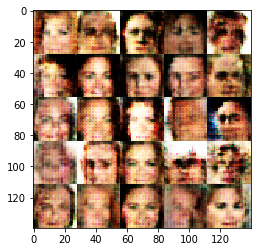

Epoch 3/5... Discriminator Loss: 1.3521... Generator Loss: 0.6112
Epoch 3/5... Discriminator Loss: 1.3450... Generator Loss: 0.6588
Epoch 3/5... Discriminator Loss: 1.3838... Generator Loss: 0.6416
Epoch 3/5... Discriminator Loss: 1.3675... Generator Loss: 0.6788
Epoch 3/5... Discriminator Loss: 1.3538... Generator Loss: 0.6218
Epoch 3/5... Discriminator Loss: 1.4031... Generator Loss: 0.6277
Epoch 3/5... Discriminator Loss: 1.3667... Generator Loss: 0.6604
Epoch 3/5... Discriminator Loss: 1.3307... Generator Loss: 0.6268
Epoch 3/5... Discriminator Loss: 1.3214... Generator Loss: 0.6406
Epoch 3/5... Discriminator Loss: 1.3750... Generator Loss: 0.7208


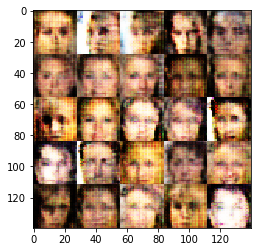

Epoch 3/5... Discriminator Loss: 1.3993... Generator Loss: 0.6930
Epoch 3/5... Discriminator Loss: 1.3379... Generator Loss: 0.6151
Epoch 3/5... Discriminator Loss: 1.2694... Generator Loss: 0.6550
Epoch 3/5... Discriminator Loss: 1.3029... Generator Loss: 0.7735
Epoch 3/5... Discriminator Loss: 1.3972... Generator Loss: 0.7287
Epoch 3/5... Discriminator Loss: 1.3272... Generator Loss: 0.6558
Epoch 3/5... Discriminator Loss: 1.3316... Generator Loss: 0.6476
Epoch 3/5... Discriminator Loss: 1.3430... Generator Loss: 0.6830
Epoch 3/5... Discriminator Loss: 1.2613... Generator Loss: 0.6577
Epoch 3/5... Discriminator Loss: 1.3092... Generator Loss: 0.6493


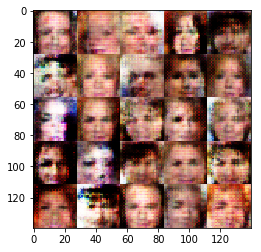

Epoch 3/5... Discriminator Loss: 1.3908... Generator Loss: 0.7152
Epoch 3/5... Discriminator Loss: 1.3874... Generator Loss: 0.6544
Epoch 3/5... Discriminator Loss: 1.3295... Generator Loss: 0.6899
Epoch 3/5... Discriminator Loss: 1.3318... Generator Loss: 0.5857
Epoch 3/5... Discriminator Loss: 1.4009... Generator Loss: 0.7435
Epoch 3/5... Discriminator Loss: 1.3553... Generator Loss: 0.6291
Epoch 3/5... Discriminator Loss: 1.3143... Generator Loss: 0.7260
Epoch 3/5... Discriminator Loss: 1.3564... Generator Loss: 0.6045
Epoch 3/5... Discriminator Loss: 1.3616... Generator Loss: 0.7007
Epoch 3/5... Discriminator Loss: 1.3399... Generator Loss: 0.7261


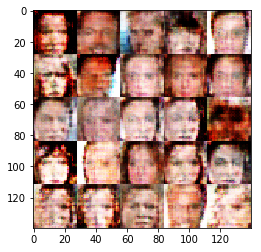

Epoch 3/5... Discriminator Loss: 1.3210... Generator Loss: 0.7229
Epoch 3/5... Discriminator Loss: 1.3700... Generator Loss: 0.6991
Epoch 3/5... Discriminator Loss: 1.3335... Generator Loss: 0.6233
Epoch 3/5... Discriminator Loss: 1.3776... Generator Loss: 0.7012
Epoch 3/5... Discriminator Loss: 1.3447... Generator Loss: 0.6929
Epoch 3/5... Discriminator Loss: 1.3418... Generator Loss: 0.6283
Epoch 3/5... Discriminator Loss: 1.3633... Generator Loss: 0.6885
Epoch 3/5... Discriminator Loss: 1.3732... Generator Loss: 0.6359
Epoch 3/5... Discriminator Loss: 1.3320... Generator Loss: 0.6722
Epoch 3/5... Discriminator Loss: 1.3480... Generator Loss: 0.6531


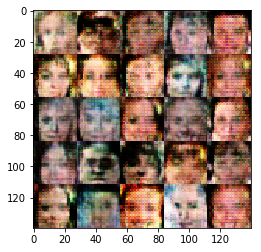

Epoch 3/5... Discriminator Loss: 1.3639... Generator Loss: 0.7020
Epoch 3/5... Discriminator Loss: 1.3909... Generator Loss: 0.7018
Epoch 3/5... Discriminator Loss: 1.3243... Generator Loss: 0.6306
Epoch 3/5... Discriminator Loss: 1.3687... Generator Loss: 0.6553
Epoch 3/5... Discriminator Loss: 1.3571... Generator Loss: 0.6468
Epoch 3/5... Discriminator Loss: 1.4499... Generator Loss: 0.7562
Epoch 3/5... Discriminator Loss: 1.2993... Generator Loss: 0.6188
Epoch 3/5... Discriminator Loss: 1.3858... Generator Loss: 0.6839
Epoch 3/5... Discriminator Loss: 1.3770... Generator Loss: 0.7050
Epoch 3/5... Discriminator Loss: 1.3897... Generator Loss: 0.6291


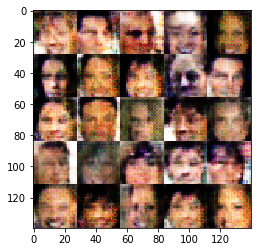

Epoch 3/5... Discriminator Loss: 1.3612... Generator Loss: 0.6764
Epoch 3/5... Discriminator Loss: 1.3646... Generator Loss: 0.6706
Epoch 3/5... Discriminator Loss: 1.3328... Generator Loss: 0.6467
Epoch 3/5... Discriminator Loss: 1.3440... Generator Loss: 0.6848
Epoch 3/5... Discriminator Loss: 1.3766... Generator Loss: 0.7194
Epoch 3/5... Discriminator Loss: 1.3199... Generator Loss: 0.6828
Epoch 3/5... Discriminator Loss: 1.3814... Generator Loss: 0.6529
Epoch 3/5... Discriminator Loss: 1.3706... Generator Loss: 0.6779
Epoch 3/5... Discriminator Loss: 1.3151... Generator Loss: 0.7260
Epoch 3/5... Discriminator Loss: 1.2948... Generator Loss: 0.6298


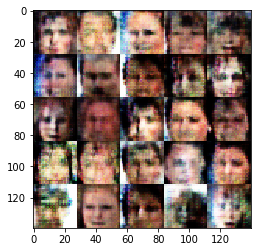

Epoch 3/5... Discriminator Loss: 1.3319... Generator Loss: 0.6956
Epoch 3/5... Discriminator Loss: 1.2864... Generator Loss: 0.7130
Epoch 3/5... Discriminator Loss: 1.2852... Generator Loss: 0.6676
Epoch 3/5... Discriminator Loss: 1.3080... Generator Loss: 0.6703
Epoch 3/5... Discriminator Loss: 1.3164... Generator Loss: 0.7959
Epoch 3/5... Discriminator Loss: 1.3471... Generator Loss: 0.8249
Epoch 3/5... Discriminator Loss: 1.3297... Generator Loss: 0.7613
Epoch 3/5... Discriminator Loss: 1.3530... Generator Loss: 0.7564
Epoch 3/5... Discriminator Loss: 1.2358... Generator Loss: 0.6515
Epoch 3/5... Discriminator Loss: 1.3029... Generator Loss: 0.7895


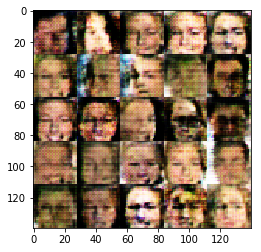

Epoch 3/5... Discriminator Loss: 1.2946... Generator Loss: 0.8517
Epoch 3/5... Discriminator Loss: 1.2491... Generator Loss: 0.8177
Epoch 3/5... Discriminator Loss: 1.1858... Generator Loss: 0.7812
Epoch 3/5... Discriminator Loss: 1.3838... Generator Loss: 1.0685
Epoch 3/5... Discriminator Loss: 1.3042... Generator Loss: 0.8010
Epoch 3/5... Discriminator Loss: 1.3038... Generator Loss: 0.8538
Epoch 3/5... Discriminator Loss: 1.3761... Generator Loss: 0.8837
Epoch 3/5... Discriminator Loss: 1.4503... Generator Loss: 0.7926
Epoch 3/5... Discriminator Loss: 1.2846... Generator Loss: 0.7278
Epoch 3/5... Discriminator Loss: 1.4480... Generator Loss: 0.9053


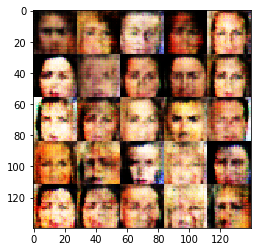

Epoch 3/5... Discriminator Loss: 1.2137... Generator Loss: 0.8582
Epoch 3/5... Discriminator Loss: 1.3026... Generator Loss: 0.8080
Epoch 3/5... Discriminator Loss: 1.4617... Generator Loss: 0.8246
Epoch 3/5... Discriminator Loss: 1.3936... Generator Loss: 0.8628
Epoch 3/5... Discriminator Loss: 1.2754... Generator Loss: 0.7768
Epoch 3/5... Discriminator Loss: 1.3177... Generator Loss: 0.7718
Epoch 3/5... Discriminator Loss: 1.3304... Generator Loss: 0.7328
Epoch 3/5... Discriminator Loss: 1.3392... Generator Loss: 0.7681
Epoch 3/5... Discriminator Loss: 1.3720... Generator Loss: 0.7396
Epoch 3/5... Discriminator Loss: 1.3529... Generator Loss: 0.7777


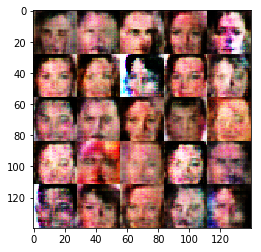

Epoch 3/5... Discriminator Loss: 1.3233... Generator Loss: 0.7761
Epoch 3/5... Discriminator Loss: 1.1978... Generator Loss: 0.8322
Epoch 3/5... Discriminator Loss: 1.2172... Generator Loss: 0.7362
Epoch 3/5... Discriminator Loss: 1.2829... Generator Loss: 0.7773
Epoch 3/5... Discriminator Loss: 1.2256... Generator Loss: 0.6327
Epoch 3/5... Discriminator Loss: 1.4280... Generator Loss: 0.9915
Epoch 3/5... Discriminator Loss: 1.2573... Generator Loss: 0.8235
Epoch 3/5... Discriminator Loss: 1.1663... Generator Loss: 0.7346
Epoch 3/5... Discriminator Loss: 1.3599... Generator Loss: 0.7900
Epoch 3/5... Discriminator Loss: 1.1620... Generator Loss: 0.7299


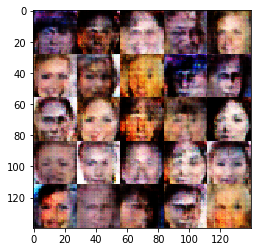

Epoch 3/5... Discriminator Loss: 1.2051... Generator Loss: 0.7037
Epoch 3/5... Discriminator Loss: 1.2993... Generator Loss: 0.7667
Epoch 3/5... Discriminator Loss: 1.3938... Generator Loss: 0.8230
Epoch 3/5... Discriminator Loss: 1.2474... Generator Loss: 0.6811
Epoch 3/5... Discriminator Loss: 1.3100... Generator Loss: 0.7621
Epoch 3/5... Discriminator Loss: 1.2415... Generator Loss: 0.7417
Epoch 3/5... Discriminator Loss: 1.3597... Generator Loss: 0.6972
Epoch 3/5... Discriminator Loss: 1.2718... Generator Loss: 0.6657
Epoch 3/5... Discriminator Loss: 1.2829... Generator Loss: 0.8384
Epoch 3/5... Discriminator Loss: 1.3711... Generator Loss: 0.7300


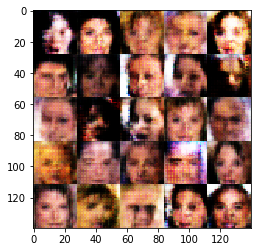

Epoch 3/5... Discriminator Loss: 1.3504... Generator Loss: 1.0991
Epoch 3/5... Discriminator Loss: 1.3198... Generator Loss: 0.7064
Epoch 3/5... Discriminator Loss: 1.2392... Generator Loss: 0.9400
Epoch 3/5... Discriminator Loss: 1.2609... Generator Loss: 0.7014
Epoch 3/5... Discriminator Loss: 1.3687... Generator Loss: 0.7274
Epoch 3/5... Discriminator Loss: 1.3287... Generator Loss: 0.6839
Epoch 3/5... Discriminator Loss: 1.2905... Generator Loss: 0.6878
Epoch 3/5... Discriminator Loss: 1.3821... Generator Loss: 0.6794
Epoch 3/5... Discriminator Loss: 1.2653... Generator Loss: 0.7787
Epoch 3/5... Discriminator Loss: 1.2680... Generator Loss: 0.8717


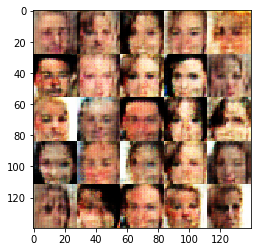

Epoch 3/5... Discriminator Loss: 1.2567... Generator Loss: 0.7017
Epoch 3/5... Discriminator Loss: 1.2064... Generator Loss: 0.8201
Epoch 3/5... Discriminator Loss: 1.2104... Generator Loss: 0.7252
Epoch 3/5... Discriminator Loss: 1.2659... Generator Loss: 0.9801
Epoch 3/5... Discriminator Loss: 1.2026... Generator Loss: 0.7525
Epoch 3/5... Discriminator Loss: 1.2248... Generator Loss: 0.7316
Epoch 3/5... Discriminator Loss: 1.2869... Generator Loss: 0.7002
Epoch 3/5... Discriminator Loss: 1.2451... Generator Loss: 0.7379
Epoch 3/5... Discriminator Loss: 1.2366... Generator Loss: 0.8910
Epoch 3/5... Discriminator Loss: 1.2153... Generator Loss: 0.7470


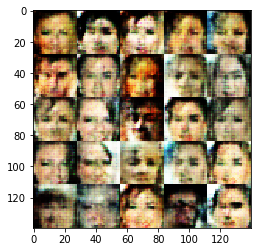

Epoch 3/5... Discriminator Loss: 1.3486... Generator Loss: 0.7667
Epoch 3/5... Discriminator Loss: 1.2834... Generator Loss: 0.7110
Epoch 3/5... Discriminator Loss: 1.2685... Generator Loss: 0.7860
Epoch 3/5... Discriminator Loss: 1.3625... Generator Loss: 0.6635
Epoch 4/5... Discriminator Loss: 1.4097... Generator Loss: 0.8517
Epoch 4/5... Discriminator Loss: 1.3990... Generator Loss: 0.7509
Epoch 4/5... Discriminator Loss: 1.3015... Generator Loss: 0.6981
Epoch 4/5... Discriminator Loss: 1.2905... Generator Loss: 0.8119
Epoch 4/5... Discriminator Loss: 1.3364... Generator Loss: 0.8263
Epoch 4/5... Discriminator Loss: 1.2581... Generator Loss: 0.7460


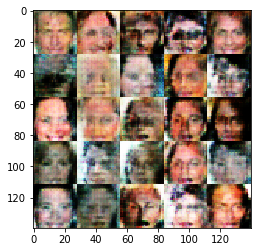

Epoch 4/5... Discriminator Loss: 1.3036... Generator Loss: 0.7595
Epoch 4/5... Discriminator Loss: 1.3463... Generator Loss: 0.8995
Epoch 4/5... Discriminator Loss: 1.4971... Generator Loss: 1.0570
Epoch 4/5... Discriminator Loss: 1.5488... Generator Loss: 0.7675
Epoch 4/5... Discriminator Loss: 1.1956... Generator Loss: 0.6639
Epoch 4/5... Discriminator Loss: 1.2467... Generator Loss: 0.8040
Epoch 4/5... Discriminator Loss: 1.3277... Generator Loss: 0.7750
Epoch 4/5... Discriminator Loss: 1.3818... Generator Loss: 1.0082
Epoch 4/5... Discriminator Loss: 1.2412... Generator Loss: 0.7264
Epoch 4/5... Discriminator Loss: 1.1825... Generator Loss: 0.7900


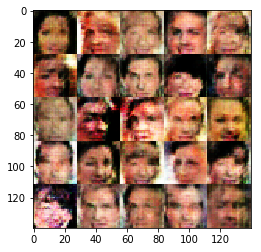

Epoch 4/5... Discriminator Loss: 1.2696... Generator Loss: 0.8701
Epoch 4/5... Discriminator Loss: 1.3303... Generator Loss: 1.0282
Epoch 4/5... Discriminator Loss: 1.2871... Generator Loss: 0.8140
Epoch 4/5... Discriminator Loss: 1.2754... Generator Loss: 0.7643
Epoch 4/5... Discriminator Loss: 1.3360... Generator Loss: 0.7397
Epoch 4/5... Discriminator Loss: 1.3568... Generator Loss: 0.8382
Epoch 4/5... Discriminator Loss: 1.3761... Generator Loss: 0.7135
Epoch 4/5... Discriminator Loss: 1.2810... Generator Loss: 0.6926
Epoch 4/5... Discriminator Loss: 1.2509... Generator Loss: 0.6911
Epoch 4/5... Discriminator Loss: 1.3185... Generator Loss: 0.6695


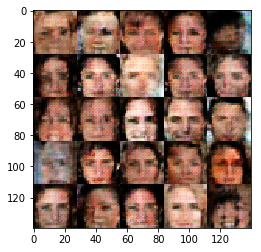

Epoch 4/5... Discriminator Loss: 1.3020... Generator Loss: 0.7373
Epoch 4/5... Discriminator Loss: 1.2330... Generator Loss: 0.6264
Epoch 4/5... Discriminator Loss: 1.2865... Generator Loss: 0.9216
Epoch 4/5... Discriminator Loss: 1.3114... Generator Loss: 0.8682
Epoch 4/5... Discriminator Loss: 1.3593... Generator Loss: 0.6904
Epoch 4/5... Discriminator Loss: 1.2797... Generator Loss: 0.7968
Epoch 4/5... Discriminator Loss: 1.3640... Generator Loss: 0.7312
Epoch 4/5... Discriminator Loss: 1.5332... Generator Loss: 0.8199
Epoch 4/5... Discriminator Loss: 1.3170... Generator Loss: 0.7294
Epoch 4/5... Discriminator Loss: 1.3196... Generator Loss: 0.8653


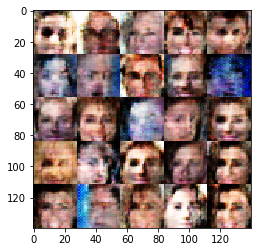

Epoch 4/5... Discriminator Loss: 1.2564... Generator Loss: 0.7469
Epoch 4/5... Discriminator Loss: 1.2656... Generator Loss: 0.8411
Epoch 4/5... Discriminator Loss: 1.3500... Generator Loss: 0.8238
Epoch 4/5... Discriminator Loss: 1.2881... Generator Loss: 0.7035
Epoch 4/5... Discriminator Loss: 1.3348... Generator Loss: 0.8340
Epoch 4/5... Discriminator Loss: 1.3078... Generator Loss: 0.8069
Epoch 4/5... Discriminator Loss: 1.2689... Generator Loss: 0.8211
Epoch 4/5... Discriminator Loss: 1.2805... Generator Loss: 0.9855
Epoch 4/5... Discriminator Loss: 1.3847... Generator Loss: 1.0373
Epoch 4/5... Discriminator Loss: 1.1568... Generator Loss: 0.7985


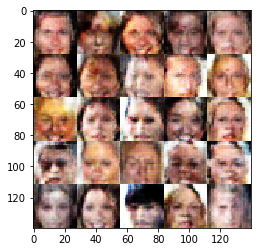

Epoch 4/5... Discriminator Loss: 1.3562... Generator Loss: 0.8770
Epoch 4/5... Discriminator Loss: 1.3487... Generator Loss: 0.7579
Epoch 4/5... Discriminator Loss: 1.3895... Generator Loss: 0.8155
Epoch 4/5... Discriminator Loss: 1.2360... Generator Loss: 0.7423
Epoch 4/5... Discriminator Loss: 1.2347... Generator Loss: 0.7950
Epoch 4/5... Discriminator Loss: 1.2812... Generator Loss: 0.8213
Epoch 4/5... Discriminator Loss: 1.3975... Generator Loss: 0.7690
Epoch 4/5... Discriminator Loss: 1.1066... Generator Loss: 0.6271
Epoch 4/5... Discriminator Loss: 1.3249... Generator Loss: 0.8607
Epoch 4/5... Discriminator Loss: 1.1181... Generator Loss: 0.7016


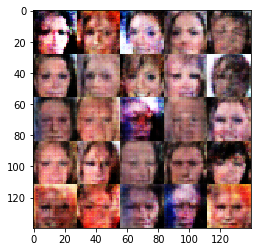

Epoch 4/5... Discriminator Loss: 1.2317... Generator Loss: 0.7309
Epoch 4/5... Discriminator Loss: 1.3670... Generator Loss: 0.8543
Epoch 4/5... Discriminator Loss: 1.3100... Generator Loss: 0.8994
Epoch 4/5... Discriminator Loss: 1.2287... Generator Loss: 0.6604
Epoch 4/5... Discriminator Loss: 1.3271... Generator Loss: 0.7349
Epoch 4/5... Discriminator Loss: 1.4912... Generator Loss: 0.8534
Epoch 4/5... Discriminator Loss: 1.4462... Generator Loss: 0.7445
Epoch 4/5... Discriminator Loss: 1.3695... Generator Loss: 0.9290
Epoch 4/5... Discriminator Loss: 1.3332... Generator Loss: 0.8930
Epoch 4/5... Discriminator Loss: 1.2434... Generator Loss: 0.7501


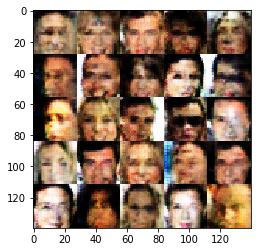

Epoch 4/5... Discriminator Loss: 1.3714... Generator Loss: 0.6867
Epoch 4/5... Discriminator Loss: 1.2685... Generator Loss: 0.7160
Epoch 4/5... Discriminator Loss: 1.2516... Generator Loss: 0.7112
Epoch 4/5... Discriminator Loss: 1.2694... Generator Loss: 0.6640
Epoch 4/5... Discriminator Loss: 1.3772... Generator Loss: 0.6971
Epoch 4/5... Discriminator Loss: 1.2947... Generator Loss: 0.7900
Epoch 4/5... Discriminator Loss: 1.3792... Generator Loss: 0.8996
Epoch 4/5... Discriminator Loss: 1.2211... Generator Loss: 0.6805
Epoch 4/5... Discriminator Loss: 1.3660... Generator Loss: 1.0298
Epoch 4/5... Discriminator Loss: 1.2506... Generator Loss: 0.8069


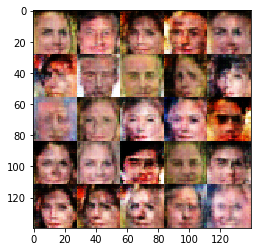

Epoch 4/5... Discriminator Loss: 1.3911... Generator Loss: 0.7046
Epoch 4/5... Discriminator Loss: 1.2962... Generator Loss: 0.8716
Epoch 4/5... Discriminator Loss: 1.3837... Generator Loss: 0.8052
Epoch 4/5... Discriminator Loss: 1.2896... Generator Loss: 0.8021
Epoch 4/5... Discriminator Loss: 1.2633... Generator Loss: 0.8855
Epoch 4/5... Discriminator Loss: 1.2280... Generator Loss: 0.7660
Epoch 4/5... Discriminator Loss: 1.2175... Generator Loss: 0.7128
Epoch 4/5... Discriminator Loss: 1.2086... Generator Loss: 0.7242
Epoch 4/5... Discriminator Loss: 1.4386... Generator Loss: 0.7814
Epoch 4/5... Discriminator Loss: 1.3293... Generator Loss: 0.7756


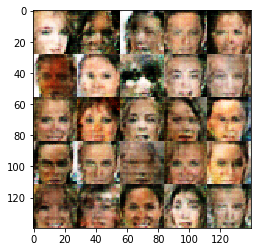

Epoch 4/5... Discriminator Loss: 1.2032... Generator Loss: 0.6700
Epoch 4/5... Discriminator Loss: 1.3037... Generator Loss: 0.7713
Epoch 4/5... Discriminator Loss: 1.2740... Generator Loss: 0.8128
Epoch 4/5... Discriminator Loss: 1.3459... Generator Loss: 0.7414
Epoch 4/5... Discriminator Loss: 1.2456... Generator Loss: 0.8992
Epoch 4/5... Discriminator Loss: 1.2301... Generator Loss: 0.9667
Epoch 4/5... Discriminator Loss: 1.3427... Generator Loss: 0.8732
Epoch 4/5... Discriminator Loss: 1.4212... Generator Loss: 0.8778
Epoch 4/5... Discriminator Loss: 1.2251... Generator Loss: 0.7195
Epoch 4/5... Discriminator Loss: 1.2891... Generator Loss: 0.8619


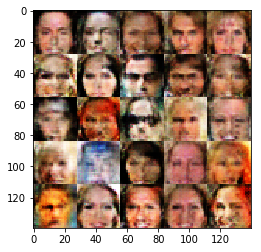

Epoch 4/5... Discriminator Loss: 1.3171... Generator Loss: 1.0500
Epoch 4/5... Discriminator Loss: 1.2537... Generator Loss: 0.7016
Epoch 4/5... Discriminator Loss: 1.0505... Generator Loss: 0.8627
Epoch 4/5... Discriminator Loss: 1.2351... Generator Loss: 1.0163
Epoch 4/5... Discriminator Loss: 1.1882... Generator Loss: 0.7642
Epoch 4/5... Discriminator Loss: 1.2654... Generator Loss: 0.7589
Epoch 4/5... Discriminator Loss: 1.3807... Generator Loss: 1.0334
Epoch 4/5... Discriminator Loss: 1.2761... Generator Loss: 0.8238
Epoch 4/5... Discriminator Loss: 1.5004... Generator Loss: 0.9337
Epoch 4/5... Discriminator Loss: 1.4005... Generator Loss: 0.9222


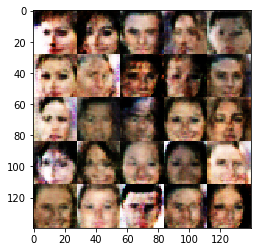

Epoch 4/5... Discriminator Loss: 1.1842... Generator Loss: 0.8048
Epoch 4/5... Discriminator Loss: 1.2697... Generator Loss: 0.7361
Epoch 4/5... Discriminator Loss: 1.4201... Generator Loss: 0.6540
Epoch 4/5... Discriminator Loss: 1.3524... Generator Loss: 1.0738
Epoch 4/5... Discriminator Loss: 1.3609... Generator Loss: 1.1328
Epoch 4/5... Discriminator Loss: 1.2800... Generator Loss: 0.8695
Epoch 4/5... Discriminator Loss: 1.1684... Generator Loss: 0.7121
Epoch 4/5... Discriminator Loss: 1.3547... Generator Loss: 0.7703
Epoch 4/5... Discriminator Loss: 1.2927... Generator Loss: 0.7232
Epoch 4/5... Discriminator Loss: 1.3278... Generator Loss: 0.8179


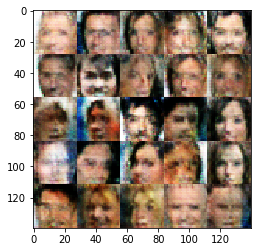

Epoch 4/5... Discriminator Loss: 1.2246... Generator Loss: 0.7534
Epoch 4/5... Discriminator Loss: 1.2492... Generator Loss: 1.0015
Epoch 4/5... Discriminator Loss: 1.3231... Generator Loss: 0.7434
Epoch 4/5... Discriminator Loss: 1.1431... Generator Loss: 0.6875
Epoch 4/5... Discriminator Loss: 1.3144... Generator Loss: 0.8420
Epoch 4/5... Discriminator Loss: 1.2738... Generator Loss: 0.7698
Epoch 4/5... Discriminator Loss: 1.3576... Generator Loss: 0.7300
Epoch 4/5... Discriminator Loss: 1.3094... Generator Loss: 0.7805
Epoch 4/5... Discriminator Loss: 1.2820... Generator Loss: 0.9970
Epoch 4/5... Discriminator Loss: 1.2332... Generator Loss: 0.7534


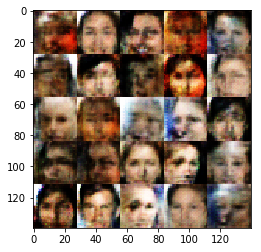

Epoch 4/5... Discriminator Loss: 1.3413... Generator Loss: 1.1992
Epoch 4/5... Discriminator Loss: 1.1308... Generator Loss: 0.7459
Epoch 4/5... Discriminator Loss: 1.2279... Generator Loss: 0.9758
Epoch 4/5... Discriminator Loss: 1.2151... Generator Loss: 0.9490
Epoch 4/5... Discriminator Loss: 1.4027... Generator Loss: 0.8909
Epoch 4/5... Discriminator Loss: 1.2178... Generator Loss: 0.6994
Epoch 4/5... Discriminator Loss: 1.2508... Generator Loss: 0.8453
Epoch 4/5... Discriminator Loss: 1.2996... Generator Loss: 0.7793
Epoch 4/5... Discriminator Loss: 1.0971... Generator Loss: 0.8240
Epoch 4/5... Discriminator Loss: 1.1657... Generator Loss: 0.7892


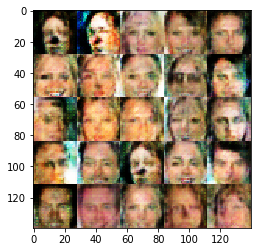

Epoch 4/5... Discriminator Loss: 1.2026... Generator Loss: 0.9292
Epoch 4/5... Discriminator Loss: 1.2312... Generator Loss: 0.8450
Epoch 4/5... Discriminator Loss: 1.2592... Generator Loss: 0.8210
Epoch 4/5... Discriminator Loss: 1.1821... Generator Loss: 1.0501
Epoch 4/5... Discriminator Loss: 1.2817... Generator Loss: 0.9653
Epoch 4/5... Discriminator Loss: 1.2076... Generator Loss: 0.7701
Epoch 4/5... Discriminator Loss: 1.3308... Generator Loss: 0.8198
Epoch 4/5... Discriminator Loss: 1.2315... Generator Loss: 0.8277
Epoch 4/5... Discriminator Loss: 1.2343... Generator Loss: 0.9383
Epoch 4/5... Discriminator Loss: 1.3036... Generator Loss: 0.8939


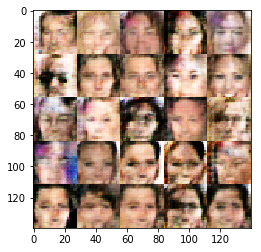

Epoch 4/5... Discriminator Loss: 1.2622... Generator Loss: 0.8301
Epoch 4/5... Discriminator Loss: 1.3873... Generator Loss: 0.8291
Epoch 4/5... Discriminator Loss: 1.2068... Generator Loss: 0.8336
Epoch 4/5... Discriminator Loss: 1.3249... Generator Loss: 0.8421
Epoch 4/5... Discriminator Loss: 1.2530... Generator Loss: 0.7485
Epoch 4/5... Discriminator Loss: 1.4703... Generator Loss: 0.9870
Epoch 4/5... Discriminator Loss: 1.1367... Generator Loss: 0.8578
Epoch 4/5... Discriminator Loss: 1.2881... Generator Loss: 0.8736
Epoch 4/5... Discriminator Loss: 1.3538... Generator Loss: 0.7936
Epoch 4/5... Discriminator Loss: 1.2573... Generator Loss: 0.8073


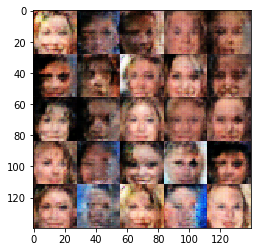

Epoch 4/5... Discriminator Loss: 1.3470... Generator Loss: 0.7993
Epoch 4/5... Discriminator Loss: 1.2649... Generator Loss: 0.9446
Epoch 5/5... Discriminator Loss: 1.1661... Generator Loss: 0.8395
Epoch 5/5... Discriminator Loss: 1.3826... Generator Loss: 1.2104
Epoch 5/5... Discriminator Loss: 1.3563... Generator Loss: 1.0738
Epoch 5/5... Discriminator Loss: 1.1551... Generator Loss: 0.8453
Epoch 5/5... Discriminator Loss: 1.3288... Generator Loss: 0.7568
Epoch 5/5... Discriminator Loss: 1.2604... Generator Loss: 0.9587
Epoch 5/5... Discriminator Loss: 1.3380... Generator Loss: 0.9482
Epoch 5/5... Discriminator Loss: 1.4073... Generator Loss: 0.9098


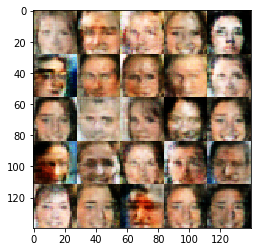

Epoch 5/5... Discriminator Loss: 1.1572... Generator Loss: 0.8654
Epoch 5/5... Discriminator Loss: 1.1460... Generator Loss: 0.8549
Epoch 5/5... Discriminator Loss: 1.2605... Generator Loss: 0.9399
Epoch 5/5... Discriminator Loss: 1.5280... Generator Loss: 0.9663
Epoch 5/5... Discriminator Loss: 1.3206... Generator Loss: 0.8131
Epoch 5/5... Discriminator Loss: 1.2155... Generator Loss: 0.7999
Epoch 5/5... Discriminator Loss: 1.3281... Generator Loss: 0.7859
Epoch 5/5... Discriminator Loss: 1.2630... Generator Loss: 0.6421
Epoch 5/5... Discriminator Loss: 1.2023... Generator Loss: 0.9272
Epoch 5/5... Discriminator Loss: 1.3802... Generator Loss: 0.7387


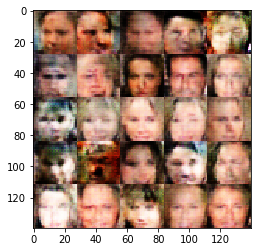

Epoch 5/5... Discriminator Loss: 1.3444... Generator Loss: 0.7819
Epoch 5/5... Discriminator Loss: 1.2981... Generator Loss: 0.6348
Epoch 5/5... Discriminator Loss: 1.2265... Generator Loss: 0.8466
Epoch 5/5... Discriminator Loss: 1.3278... Generator Loss: 1.0016
Epoch 5/5... Discriminator Loss: 1.2832... Generator Loss: 0.8422
Epoch 5/5... Discriminator Loss: 1.4121... Generator Loss: 1.0600
Epoch 5/5... Discriminator Loss: 1.1713... Generator Loss: 0.8084
Epoch 5/5... Discriminator Loss: 1.2755... Generator Loss: 0.8127
Epoch 5/5... Discriminator Loss: 1.2578... Generator Loss: 0.9062
Epoch 5/5... Discriminator Loss: 1.3752... Generator Loss: 0.6948


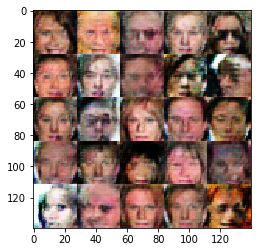

Epoch 5/5... Discriminator Loss: 1.2711... Generator Loss: 0.7764
Epoch 5/5... Discriminator Loss: 1.3658... Generator Loss: 0.9449
Epoch 5/5... Discriminator Loss: 1.1644... Generator Loss: 0.8435
Epoch 5/5... Discriminator Loss: 1.4140... Generator Loss: 0.7255
Epoch 5/5... Discriminator Loss: 1.2752... Generator Loss: 0.8826
Epoch 5/5... Discriminator Loss: 1.2069... Generator Loss: 0.7096
Epoch 5/5... Discriminator Loss: 1.3227... Generator Loss: 0.7053
Epoch 5/5... Discriminator Loss: 1.1788... Generator Loss: 0.8346
Epoch 5/5... Discriminator Loss: 1.4447... Generator Loss: 0.8869
Epoch 5/5... Discriminator Loss: 1.2278... Generator Loss: 0.9496


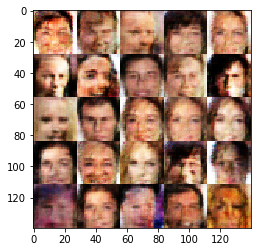

Epoch 5/5... Discriminator Loss: 1.2196... Generator Loss: 0.7831
Epoch 5/5... Discriminator Loss: 1.2524... Generator Loss: 0.7669
Epoch 5/5... Discriminator Loss: 1.2438... Generator Loss: 0.9637
Epoch 5/5... Discriminator Loss: 1.2542... Generator Loss: 0.8407
Epoch 5/5... Discriminator Loss: 1.1119... Generator Loss: 0.7929
Epoch 5/5... Discriminator Loss: 1.2542... Generator Loss: 0.9395
Epoch 5/5... Discriminator Loss: 1.2597... Generator Loss: 0.8646
Epoch 5/5... Discriminator Loss: 1.3152... Generator Loss: 0.8827
Epoch 5/5... Discriminator Loss: 1.2539... Generator Loss: 0.8444
Epoch 5/5... Discriminator Loss: 1.1733... Generator Loss: 0.9271


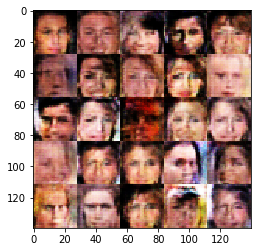

Epoch 5/5... Discriminator Loss: 1.3444... Generator Loss: 1.1345
Epoch 5/5... Discriminator Loss: 1.2820... Generator Loss: 0.8846
Epoch 5/5... Discriminator Loss: 1.2773... Generator Loss: 0.7701
Epoch 5/5... Discriminator Loss: 1.3519... Generator Loss: 0.8259
Epoch 5/5... Discriminator Loss: 1.2090... Generator Loss: 0.9656
Epoch 5/5... Discriminator Loss: 1.2145... Generator Loss: 0.7708
Epoch 5/5... Discriminator Loss: 1.1780... Generator Loss: 0.7087
Epoch 5/5... Discriminator Loss: 1.1298... Generator Loss: 0.7407
Epoch 5/5... Discriminator Loss: 1.3268... Generator Loss: 1.0196
Epoch 5/5... Discriminator Loss: 1.1066... Generator Loss: 0.8954


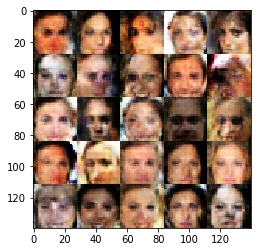

Epoch 5/5... Discriminator Loss: 1.0624... Generator Loss: 0.7680
Epoch 5/5... Discriminator Loss: 1.1530... Generator Loss: 1.0097
Epoch 5/5... Discriminator Loss: 1.0989... Generator Loss: 0.8526
Epoch 5/5... Discriminator Loss: 1.3641... Generator Loss: 0.8858
Epoch 5/5... Discriminator Loss: 1.2413... Generator Loss: 0.7814
Epoch 5/5... Discriminator Loss: 1.1644... Generator Loss: 1.0512
Epoch 5/5... Discriminator Loss: 1.4721... Generator Loss: 0.9233
Epoch 5/5... Discriminator Loss: 1.1359... Generator Loss: 0.8141
Epoch 5/5... Discriminator Loss: 1.3070... Generator Loss: 0.8729
Epoch 5/5... Discriminator Loss: 1.5396... Generator Loss: 0.9746


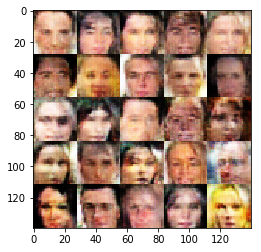

Epoch 5/5... Discriminator Loss: 1.3172... Generator Loss: 0.8257
Epoch 5/5... Discriminator Loss: 1.4705... Generator Loss: 0.7908
Epoch 5/5... Discriminator Loss: 1.2269... Generator Loss: 0.7124
Epoch 5/5... Discriminator Loss: 1.1879... Generator Loss: 1.0551
Epoch 5/5... Discriminator Loss: 1.0903... Generator Loss: 0.6887
Epoch 5/5... Discriminator Loss: 1.2847... Generator Loss: 0.7114
Epoch 5/5... Discriminator Loss: 1.4685... Generator Loss: 0.7361
Epoch 5/5... Discriminator Loss: 1.3244... Generator Loss: 0.8207
Epoch 5/5... Discriminator Loss: 1.2984... Generator Loss: 0.7413
Epoch 5/5... Discriminator Loss: 1.2502... Generator Loss: 0.7384


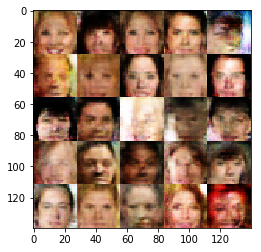

Epoch 5/5... Discriminator Loss: 1.2133... Generator Loss: 0.7693
Epoch 5/5... Discriminator Loss: 1.2263... Generator Loss: 0.7637
Epoch 5/5... Discriminator Loss: 1.2564... Generator Loss: 0.8158
Epoch 5/5... Discriminator Loss: 1.2161... Generator Loss: 0.7883
Epoch 5/5... Discriminator Loss: 1.2136... Generator Loss: 1.0389
Epoch 5/5... Discriminator Loss: 1.2562... Generator Loss: 0.8202
Epoch 5/5... Discriminator Loss: 1.2228... Generator Loss: 0.9198
Epoch 5/5... Discriminator Loss: 1.2303... Generator Loss: 1.2590
Epoch 5/5... Discriminator Loss: 1.2489... Generator Loss: 0.7803
Epoch 5/5... Discriminator Loss: 1.2280... Generator Loss: 0.7766


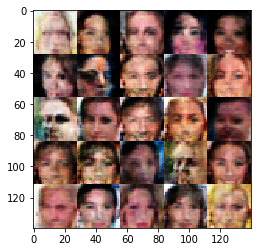

Epoch 5/5... Discriminator Loss: 1.2715... Generator Loss: 0.8654
Epoch 5/5... Discriminator Loss: 1.2291... Generator Loss: 0.7872
Epoch 5/5... Discriminator Loss: 1.0673... Generator Loss: 0.8740
Epoch 5/5... Discriminator Loss: 1.3951... Generator Loss: 0.8059
Epoch 5/5... Discriminator Loss: 1.2615... Generator Loss: 1.1201
Epoch 5/5... Discriminator Loss: 1.3877... Generator Loss: 0.7456
Epoch 5/5... Discriminator Loss: 1.1183... Generator Loss: 0.6863
Epoch 5/5... Discriminator Loss: 1.2305... Generator Loss: 0.8959
Epoch 5/5... Discriminator Loss: 1.1195... Generator Loss: 0.9043
Epoch 5/5... Discriminator Loss: 1.2260... Generator Loss: 0.8316


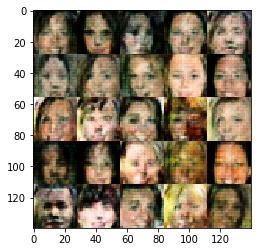

Epoch 5/5... Discriminator Loss: 1.3278... Generator Loss: 0.7199
Epoch 5/5... Discriminator Loss: 1.2345... Generator Loss: 0.6877
Epoch 5/5... Discriminator Loss: 1.3436... Generator Loss: 0.8837
Epoch 5/5... Discriminator Loss: 1.2778... Generator Loss: 0.9973
Epoch 5/5... Discriminator Loss: 1.2449... Generator Loss: 0.7058
Epoch 5/5... Discriminator Loss: 1.4472... Generator Loss: 1.2128
Epoch 5/5... Discriminator Loss: 1.1654... Generator Loss: 0.9055
Epoch 5/5... Discriminator Loss: 1.3874... Generator Loss: 0.8254
Epoch 5/5... Discriminator Loss: 1.2165... Generator Loss: 0.8905
Epoch 5/5... Discriminator Loss: 1.4166... Generator Loss: 1.0115


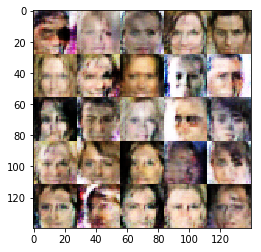

Epoch 5/5... Discriminator Loss: 1.1992... Generator Loss: 0.8271
Epoch 5/5... Discriminator Loss: 1.4386... Generator Loss: 0.9014
Epoch 5/5... Discriminator Loss: 1.3659... Generator Loss: 0.8144
Epoch 5/5... Discriminator Loss: 1.1388... Generator Loss: 0.8568
Epoch 5/5... Discriminator Loss: 1.3754... Generator Loss: 0.7675
Epoch 5/5... Discriminator Loss: 1.2999... Generator Loss: 1.0084
Epoch 5/5... Discriminator Loss: 1.1563... Generator Loss: 0.8556
Epoch 5/5... Discriminator Loss: 1.1719... Generator Loss: 0.9268
Epoch 5/5... Discriminator Loss: 1.2991... Generator Loss: 1.1698
Epoch 5/5... Discriminator Loss: 1.2166... Generator Loss: 0.7464


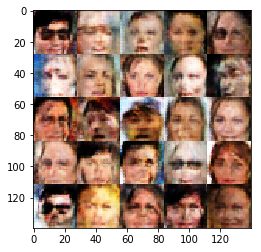

Epoch 5/5... Discriminator Loss: 1.1630... Generator Loss: 0.8241
Epoch 5/5... Discriminator Loss: 1.4229... Generator Loss: 0.7869
Epoch 5/5... Discriminator Loss: 1.4313... Generator Loss: 1.1511
Epoch 5/5... Discriminator Loss: 1.3471... Generator Loss: 0.7646
Epoch 5/5... Discriminator Loss: 1.1104... Generator Loss: 1.0993
Epoch 5/5... Discriminator Loss: 1.3446... Generator Loss: 0.8650
Epoch 5/5... Discriminator Loss: 1.3397... Generator Loss: 0.9572
Epoch 5/5... Discriminator Loss: 1.1523... Generator Loss: 0.7114
Epoch 5/5... Discriminator Loss: 1.1373... Generator Loss: 0.9683
Epoch 5/5... Discriminator Loss: 1.3496... Generator Loss: 0.7540


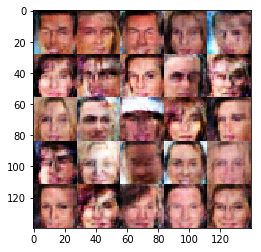

Epoch 5/5... Discriminator Loss: 1.2552... Generator Loss: 0.8898
Epoch 5/5... Discriminator Loss: 1.2424... Generator Loss: 0.8704
Epoch 5/5... Discriminator Loss: 1.3030... Generator Loss: 1.0519
Epoch 5/5... Discriminator Loss: 1.2376... Generator Loss: 1.0253
Epoch 5/5... Discriminator Loss: 1.2519... Generator Loss: 0.8074
Epoch 5/5... Discriminator Loss: 1.4917... Generator Loss: 0.6347
Epoch 5/5... Discriminator Loss: 1.3664... Generator Loss: 0.9410
Epoch 5/5... Discriminator Loss: 1.3053... Generator Loss: 0.7387
Epoch 5/5... Discriminator Loss: 1.4056... Generator Loss: 1.0836
Epoch 5/5... Discriminator Loss: 1.1928... Generator Loss: 0.8428


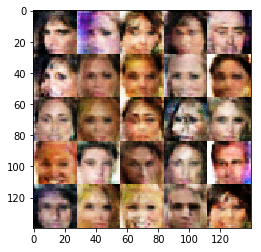

Epoch 5/5... Discriminator Loss: 1.1340... Generator Loss: 0.7891
Epoch 5/5... Discriminator Loss: 1.2976... Generator Loss: 0.8949
Epoch 5/5... Discriminator Loss: 1.2916... Generator Loss: 0.9029
Epoch 5/5... Discriminator Loss: 1.2063... Generator Loss: 0.7706
Epoch 5/5... Discriminator Loss: 1.3369... Generator Loss: 0.9987
Epoch 5/5... Discriminator Loss: 1.4419... Generator Loss: 0.9059
Epoch 5/5... Discriminator Loss: 1.4016... Generator Loss: 0.9292
Epoch 5/5... Discriminator Loss: 1.2486... Generator Loss: 0.7113
Epoch 5/5... Discriminator Loss: 1.2527... Generator Loss: 0.9298
Epoch 5/5... Discriminator Loss: 1.2486... Generator Loss: 0.8698


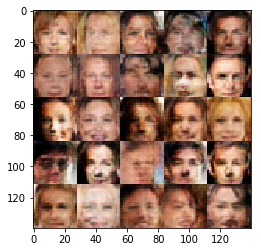

Epoch 5/5... Discriminator Loss: 1.1243... Generator Loss: 0.7996
Epoch 5/5... Discriminator Loss: 1.2198... Generator Loss: 0.9417
Epoch 5/5... Discriminator Loss: 1.0184... Generator Loss: 0.8762
Epoch 5/5... Discriminator Loss: 1.2612... Generator Loss: 0.8815
Epoch 5/5... Discriminator Loss: 1.2663... Generator Loss: 1.0216
Epoch 5/5... Discriminator Loss: 1.2601... Generator Loss: 0.8300
Epoch 5/5... Discriminator Loss: 1.3399... Generator Loss: 0.7994
Epoch 5/5... Discriminator Loss: 1.1213... Generator Loss: 0.8932
Epoch 5/5... Discriminator Loss: 1.2693... Generator Loss: 0.7571
Epoch 5/5... Discriminator Loss: 1.3903... Generator Loss: 1.3026


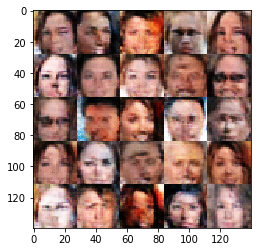

Epoch 5/5... Discriminator Loss: 1.1727... Generator Loss: 0.9344


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.004
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.